In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch
!pip install kogpt2_transformers
!pip install transformers

import torch
import torch.nn as nn

from kogpt2_transformers import get_kogpt2_tokenizer

### 행별 토큰 개수 확인

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_excel('/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM/data/wellness_dialog_dataset.xlsx')
data = df[['유저','챗봇']][0:3]

tokenizer = get_kogpt2_tokenizer()
n_ctx = 1024
bos_token_id = [tokenizer.bos_token_id]  # [0]
eos_token_id = [tokenizer.eos_token_id]  # [1]
pad_token_id = [tokenizer.pad_token_id]  # [3]
print(bos_token_id, eos_token_id,pad_token_id )

print(len(tokenizer.encode(data['유저'][0])))  # 첫번째 행 유저 발화 토큰 개수 : 21

token_data_user_list = []
token_user_number = []
for idx, row in df[['유저']].iterrows():
  # print(row.values[0])
  token_row = tokenizer.encode(row.values[0])
  token_data_user_list.append(token_row)
  token_user_number.append(len(token_row))


token_data_bot_list = []
token_bot_number = []
print(len(tokenizer.encode(data['챗봇'][0])))  # 첫번째 행 챗봇 발화 토큰 개수 : 13
for idx, row in df[['챗봇']].iterrows():
  # if not row.isna().values[0]:
  if not pd.isna(row).any():
    # print(row.values[0])
    token_row = tokenizer.encode(row.values[0])
    token_data_bot_list.append(token_row)
    token_bot_number.append(len(token_row))
  else:
    continue

# index_of_words = bos_token_id + tokenizer.encode(data['유저'][0]) + eos_token_id + bos_token_id + tokenizer.encode(data['챗봇'][0])+ eos_token_id
# pad_token_len = n_ctx - len(index_of_words)
# index_of_words += pad_token_id * pad_token_len
# index_of_words
# data.append(index_of_words)

12.403555725482699
2
41
13.238878143133462
3
29


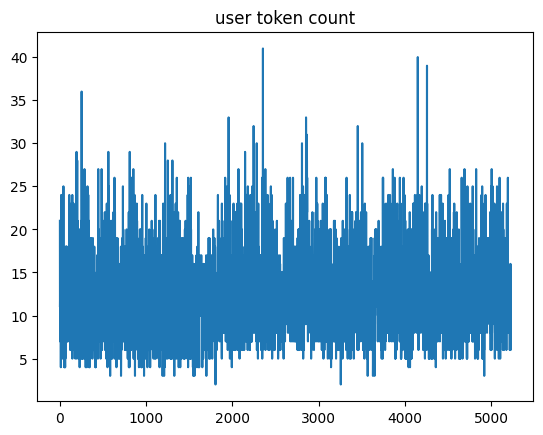

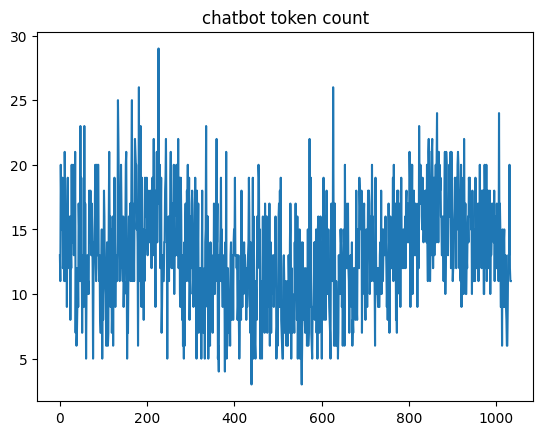

In [ ]:
print(np.mean(token_user_number))  # 유저발화 토큰 평균 개수 : 12.403555725482699
print(np.min(token_user_number))  # 유저발화 토큰 최소 개수 : 2
print(np.max(token_user_number))  # 유저발화 토큰 최대 개수 : 41

print(np.mean(token_bot_number))  # 챗봇발화 토큰 평균 개수 : 13.238878143133462
print(np.min(token_bot_number))  # 챗봇발화 토큰 최소 개수 : 3
print(np.max(token_bot_number))  # 챗봇발화 토큰 최대 개수 : 29

import matplotlib.pyplot as plt
plt.plot(token_user_number)
plt.title('user token count')
plt.show()

plt.plot(token_bot_number)
plt.title('chatbot token count')
plt.show()

---

In [ ]:
df.columns

Index(['구분', '유저', '챗봇'], dtype='object')

In [ ]:
df['유저'].count()

np.int64(5231)

In [ ]:
df['챗봇'].count()

np.int64(1034)

In [ ]:
df['구분'].nunique()

359

In [ ]:
# 359개의 구분, 유저발화 5231개, 챗봇발화 1,034개

---

### 챗봇 발화 누락 확인

In [25]:
df.groupby('구분')['챗봇'].count()[df.groupby('구분')['챗봇'].count() == 0]

,챗봇
구분,
배경/부모/죽음,0
일반대화,0
현재상태/증상감소,0
현재상태/증상지속,0


In [ ]:
pd.options.display.max_rows = None

In [22]:
import pandas as pd

# df: ["구분", "유저", "챗봇"] 컬럼이 있는 데이터프레임

# 1. 챗봇 발화가 있는 행만 필터링해서 카테고리별 카운트
bot_counts = df[~df["챗봇"].isna()].groupby("구분")["챗봇"].count().reset_index(name="챗봇_발화_수")

# 2. 전체 카테고리별 유저 발화 수
user_counts = df.groupby("구분")["유저"].count().reset_index(name="유저_발화_수")

# 3. 병합 후 챗봇 발화 없는 카테고리만 필터링 (NaN 처리)
merged = pd.merge(user_counts, bot_counts, on="구분", how="left")
merged["챗봇_발화_수"] = merged["챗봇_발화_수"].fillna(0).astype(int)

# 4. 챗봇 발화가 0개인 카테고리만 보기
missing_bot = merged[merged["챗봇_발화_수"] == 0]

# 결과 출력
print(f"챗봇 발화가 없는 카테고리 수: {len(missing_bot)}개\n")
print(missing_bot[["구분", "유저_발화_수"]])


챗봇 발화가 없는 카테고리 수: 4개

            구분  유저_발화_수
162   배경/부모/죽음       11
258       일반대화       21
356  현재상태/증상감소        6
358  현재상태/증상지속        7


---

### 챗봇 발화 중복 확인

In [ ]:
df_drop = df['챗봇'].dropna()
df_drop

,챗봇
0,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
1,저도 그 기분 이해해요. 많이 힘드시죠?
2,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요."
15,화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.
16,정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.
...,...
5196,응급실이 있어서 다행이네요. 큰 문제는 없으신 거죠?
5197,응급실에 가셨다니 정말 놀랐어요. 아무 문제 없으신가요? 걱정 되네요.
5213,상태가 더 안 좋아지셨군요. 걱정이 되네요.
5214,정말 힘드시겠어요. 지금도 증상이 심하신가요?


In [ ]:
df_drop[df_drop.duplicated()]

,챗봇
2409,그런 일이 있으셨군요.
2410,"네, 더 말씀해주세요."
2411,"아, 그렇군요."
2620,"네, 그렇군요."
2810,"아, 그렇군요."
2828,"아, 그렇군요."
2839,그렇군요.
2840,"네, 더 말씀해주세요."
2880,그런 일이 있으셨군요.
3189,"아, 그렇군요."


In [ ]:
bot_duplicated_all = df_drop[df_drop.duplicated()].unique()
bot_duplicated_all

array(['그런 일이 있으셨군요. ', '네, 더 말씀해주세요.', '아, 그렇군요.', '네, 그렇군요.', '그렇군요.',
       '그런 일이 있으셨군요.', '아, 그렇군요. ', '정말 힘드셨겠어요. 지금은 괜찮으세요?'], dtype=object)

### 챗봇 발화 중복이 발생한 '카테고리'의 '유저 발화' 수 체크

In [ ]:
df[df['챗봇'].isin(bot_duplicated_all)]

,구분,유저,챗봇
1651,모호함,그런데 살아보니까 그렇지도 않아요.,그런 일이 있으셨군요.
2033,배경/군대/군입대,형은 내년에 입대한다.,"네, 그렇군요."
2038,배경/귀국,스페인에서 지내다가 한국에 돌아온 지 얼마 안 됐어요.,그런 일이 있으셨군요.
2107,배경/남편,남편이 갑자기 나한테 고백할 게 있다고 하더라.,"네, 더 말씀해주세요."
2298,배경/대학,조금 늦더라도 대학을 꼭 가야겠더라.,"아, 그렇군요."
2393,배경/문제/불편감/옷,집에서는 아예 벗고 지내요.,그렇군요.
2409,배경/부모,아빠는 진짜 오래 사실 줄 알았어.,그런 일이 있으셨군요.
2410,배경/부모,"방학 때나 가끔 올라와서 병원에 가서 엄마를 만나고 오긴 해요. 근데 별 감정도, ...","네, 더 말씀해주세요."
2411,배경/부모,두 분이서 같이 장사를 하셨었거든요.,"아, 그렇군요."
2620,배경/생활,원래 학교 다닐 때부터 쭉 파주에 살았어요.,"네, 그렇군요."


In [ ]:
df[df['챗봇'].isin(bot_duplicated_all)]['구분'].unique()  # 총 16개 카테고리

array(['모호함', '배경/군대/군입대', '배경/귀국', '배경/남편', '배경/대학', '배경/문제/불편감/옷',
       '배경/부모', '배경/생활', '배경/성격/완벽추구', '배경/성격/자기중심적', '배경/시댁', '배경/애완동물',
       '배경/여자친구', '배경/전연인', '증상/발작', '증상/신체이상/목'], dtype=object)

In [ ]:
duple_category = df[df['챗봇'].isin(bot_duplicated_all)]['구분'].unique()
duple_category

array(['모호함', '배경/군대/군입대', '배경/귀국', '배경/남편', '배경/대학', '배경/문제/불편감/옷',
       '배경/부모', '배경/생활', '배경/성격/완벽추구', '배경/성격/자기중심적', '배경/시댁', '배경/애완동물',
       '배경/여자친구', '배경/전연인', '증상/발작', '증상/신체이상/목'], dtype=object)

In [ ]:
df.groupby('구분')['유저'].count()

,유저
구분,
감정/감정조절이상,15
감정/감정조절이상/화,6
감정/걱정,78
감정/걱정/건강문제,9
감정/걱정/건강염려,13
...,...
치료이력/병원내원/이상없음,14
치료이력/응급실,12
현재상태/증상감소,6


In [ ]:
df['구분'].value_counts()

,count
구분,
증상/불면,209
모호함,180
감정/힘듦,106
감정/자살충동,94
감정/부정적사고,93
...,...
감정/기시감,5
증상/식욕저하/체중감소,5
증상/죽음공포/호흡곤란,5


In [ ]:
category_count_df = df['구분'].value_counts()

In [ ]:
category_count_df[duple_category].sort_values(ascending=True)

,count
구분,
배경/군대/군입대,5
배경/문제/불편감/옷,5
배경/성격/자기중심적,5
배경/귀국,6
증상/신체이상/목,6
증상/발작,6
배경/전연인,7
배경/애완동물,9
배경/성격/완벽추구,12


In [ ]:
category_count_df[duple_category].sum()  # 챗봇 발화가 중복된 카테고리의 유저발화수 총 405개/5031개(8%)

np.int64(405)

---

### 카테고리별 유저 발화 개수

In [ ]:
df.groupby('구분')['유저'].count()

,유저
구분,
감정/감정조절이상,15
감정/감정조절이상/화,6
감정/걱정,78
감정/걱정/건강문제,9
감정/걱정/건강염려,13
...,...
치료이력/병원내원/이상없음,14
치료이력/응급실,12
현재상태/증상감소,6


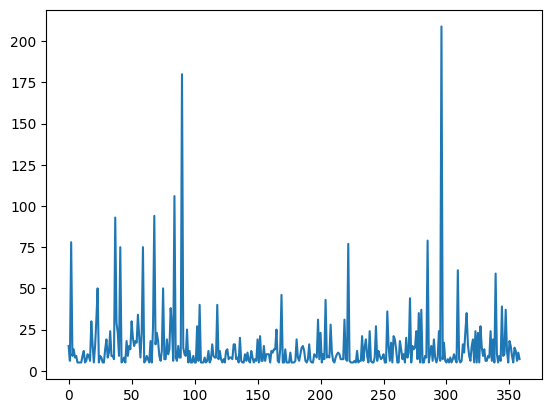

In [ ]:
plt.plot(range(359),df.groupby('구분')['유저'].count())
plt.show()

---

### 카테고리 개수 줄일 수 있는지 검토

In [ ]:
df['구분'].unique()

array(['감정/감정조절이상', '감정/감정조절이상/화', '감정/걱정', '감정/걱정/건강문제', '감정/걱정/건강염려',
       '감정/걱정/경제적문제', '감정/걱정/미래', '감정/걱정/불면', '감정/걱정/암', '감정/걱정/자녀',
       '감정/걱정/주변평가', '감정/걱정/증상재발', '감정/고독감', '감정/곤혹감', '감정/공포', '감정/공포/새',
       '감정/공허감', '감정/과민반응', '감정/괴로움', '감정/기분저하', '감정/기시감', '감정/긴장',
       '감정/눈물', '감정/답답', '감정/답답/사람많은곳', '감정/당황', '감정/두려움', '감정/두려움/운전',
       '감정/두려움/자동차', '감정/멍함', '감정/모호함', '감정/무력감', '감정/무미건조', '감정/무서움',
       '감정/미안함/자녀', '감정/미움', '감정/배신감', '감정/부정적사고', '감정/분노', '감정/불만',
       '감정/불신', '감정/불안감', '감정/불안감/긴장', '감정/불안감/미래', '감정/불안감/증상재발',
       '감정/불안감/초조함', '감정/불쾌감', '감정/불편감', '감정/비관적', '감정/살인욕구', '감정/생각',
       '감정/서운함', '감정/속상함', '감정/슬픔', '감정/신경쓰임', '감정/심란', '감정/억울함',
       '감정/예민함', '감정/외로움', '감정/우울감', '감정/우울감/눈물', '감정/우울감/증상재발',
       '감정/우울감/증상지속', '감정/의기소침', '감정/의기소침/자격지심', '감정/의욕상실', '감정/의욕상실/무기력',
       '감정/자괴감', '감정/자살충동', '감정/자신감저하', '감정/자존감저하', '감정/절망감', '감정/좌절',
       '감정/죄책감', '감정/즐거움', '감정/짜증', '감정/창피함', '감정/초조함', '감정/충격',
       '감정/통제력상실', '감정/허

In [ ]:
category_list = df['구분'].unique()

unique_values = set(['/'.join(item.split('/')[:2]) for item in category_list])

# 유니크한 값 개수 출력  
print(len(unique_values))  # 줄여도 177개..?

177


In [ ]:
unique_values

{'감정/감정조절이상',
 '감정/걱정',
 '감정/고독감',
 '감정/곤혹감',
 '감정/공포',
 '감정/공허감',
 '감정/과민반응',
 '감정/괴로움',
 '감정/기분저하',
 '감정/기시감',
 '감정/긴장',
 '감정/눈물',
 '감정/답답',
 '감정/당황',
 '감정/두려움',
 '감정/멍함',
 '감정/모호함',
 '감정/무력감',
 '감정/무미건조',
 '감정/무서움',
 '감정/미안함',
 '감정/미움',
 '감정/배신감',
 '감정/부정적사고',
 '감정/분노',
 '감정/불만',
 '감정/불신',
 '감정/불안감',
 '감정/불쾌감',
 '감정/불편감',
 '감정/비관적',
 '감정/살인욕구',
 '감정/생각',
 '감정/서운함',
 '감정/속상함',
 '감정/슬픔',
 '감정/신경쓰임',
 '감정/심란',
 '감정/억울함',
 '감정/예민함',
 '감정/외로움',
 '감정/우울감',
 '감정/의기소침',
 '감정/의욕상실',
 '감정/자괴감',
 '감정/자살충동',
 '감정/자신감저하',
 '감정/자존감저하',
 '감정/절망감',
 '감정/좌절',
 '감정/죄책감',
 '감정/즐거움',
 '감정/짜증',
 '감정/창피함',
 '감정/초조함',
 '감정/충격',
 '감정/통제력상실',
 '감정/허무함',
 '감정/화',
 '감정/후회',
 '감정/힘듦',
 '내원이유/상담',
 '내원이유/의사소견',
 '내원이유/치료',
 '모호함',
 '배경/가족',
 '배경/건강문제',
 '배경/결혼',
 '배경/경제적문제',
 '배경/공부',
 '배경/군대',
 '배경/귀국',
 '배경/남자친구',
 '배경/남편',
 '배경/대인관계',
 '배경/대학',
 '배경/문제',
 '배경/부모',
 '배경/사고',
 '배경/사업',
 '배경/생활',
 '배경/성격',
 '배경/시댁',
 '배경/아르바이트',
 '배경/애완동물',
 '배경/어린시절',
 '배경/여자친구',
 '배경/연애',
 '배경/유학',
 '배경/육아',
 '배경/음주',
 '배경/이사

In [ ]:
pd.Series(df['구분'].unique()).str.split('/',expand=True)[[0,1]]

,0,1
0,감정,감정조절이상
1,감정,감정조절이상
2,감정,걱정
3,감정,걱정
4,감정,걱정
...,...,...
354,치료이력,병원내원
355,치료이력,응급실
356,현재상태,증상감소
357,현재상태,증상악화


In [ ]:
pd.Series(df['구분'].unique()).str.split('/').str[:2]